![](img/330-banner.png)

# Lecture 17: Introduction to natural language processing 

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

## Imports

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


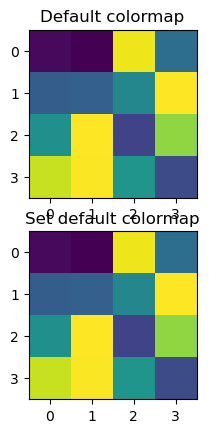

In [1]:
import os
import re
import string
import sys
import time

sys.path.append(os.path.join(os.path.abspath("."), "code"))

from plotting_functions_unsup import *

import IPython
import numpy as np
import numpy.random as npr
import pandas as pd
from comat import CooccurrenceMatrix
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from preprocessing import MyPreprocessor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kvarada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<br><br>

## Learning objectives

- Broadly explain what is natural language processing (NLP). 
- Name some common NLP applications. 
- Explain the general idea of a vector space model.
- Explain the difference between different word representations: term-term co-occurrence matrix representation and Word2Vec representation.
- Describe the reasons and benefits of using pre-trained embeddings. 
- Load and use pre-trained word embeddings to find word similarities and analogies. 
- Demonstrate biases in embeddings and learn to watch out for such biases in pre-trained embeddings.
- Use word embeddings in text classification and document clustering using `spaCy`.
- Explain the general idea of topic modeling. 
- Describe the input and output of topic modeling. 
- Carry out basic text preprocessing using `spaCy`.   

<br><br>

## What is Natural Language Processing (NLP)?

- What should a search engine return when asked the following question? 

![](img/lexical_ambiguity.png)

<!-- <center> -->
<!-- <img src="img/lexical_ambiguity.png" width="1000" height="1000"> -->
<!-- </center> -->

### What is Natural Language Processing (NLP)?
#### How often do you search everyday? 

![](img/Google_search.png)

<!-- <center> -->
<!-- <img src="img/Google_search.png" width="900" height="900"> -->
<!-- </center> -->

### What is Natural Language Processing (NLP)?

![](img/WhatisNLP.png)

<!-- <center> -->
<!-- <img src="img/WhatisNLP.png" width="800" height="800"> -->
<!-- </center> -->    

### Everyday NLP applications

![](img/annotation-image.png)
<!-- <center> -->
<!-- <img src="img/annotation-image.png" height="1200" width="1200"> -->
<!-- </center> -->

### NLP in news 

Often you'll see NLP in news. Some examples: 
- [How suicide prevention is getting a boost from artificial intelligence](https://abcnews.go.com/GMA/Wellness/suicide-prevention-boost-artificial-intelligence-exclusive/story?id=76541481)
- [Meet GPT-3. It Has Learned to Code (and Blog and Argue).](https://www.nytimes.com/2020/11/24/science/artificial-intelligence-ai-gpt3.html)
- [How Do You Know a Human Wrote This?](https://www.nytimes.com/2020/07/29/opinion/gpt-3-ai-automation.html)
- ...

### Why is NLP hard?

- Language is complex and subtle. 
- Language is ambiguous at different levels. 
- Language understanding involves common-sense knowledge and real-world reasoning.
- All the problems related to representation and reasoning in artificial intelligence arise in this domain. 

### Example: Lexical ambiguity

<br><br>

![](img/lexical_ambiguity.png)

<!-- <img src="img/lexical_ambiguity.png" width="1000" height="1000"> -->
    

### Example: Referential ambiguity
<br><br>

<!-- <img src="img/referential_ambiguity.png" width="1000" height="1000"> -->

![](img/referential_ambiguity.png)
    

### [Ambiguous news headlines](http://www.fun-with-words.com/ambiguous_headlines.html)

<blockquote>
PROSTITUTES APPEAL TO POPE
</blockquote>    

- **appeal to** means make a serious or urgent request or be attractive or interesting?

<blockquote>
KICKING BABY CONSIDERED TO BE HEALTHY    
</blockquote> 

- **kicking** is used as an adjective or a verb?

<blockquote>
MILK DRINKERS ARE TURNING TO POWDER
</blockquote>

- **turning** means becoming or take up?

### Overall goal

- Give you a quick introduction to you of this important field in artificial intelligence which extensively used machine learning.   

![](img/NLP_in_industry.png)

<!-- <center> -->
<!-- <img src="img/NLP_in_industry.png" width="900" height="800"> -->
<!-- </center> -->

Today's plan

- Word embeddings
- Topic modeling 
- Basic text preprocessing 

<br><br>

## Word embeddings

In [3]:
# It'll take a while to run this when you try it out for the first time.
import gensim.downloader as api

google_news_vectors = api.load("word2vec-google-news-300")

In [4]:
def analogy(word1, word2, word3, model=google_news_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

In [5]:
analogy("Italy", "pizza", "Japan")

Italy : pizza :: Japan : ?


,Analogy word,Score
0,sushi,0.542754
1,ramen,0.541916
2,bento,0.539965
3,teriyaki,0.502705
4,yakisoba,0.502351
5,takoyaki,0.501550
6,onigiri,0.501540
7,burger,0.495270
8,ramen_noodle,0.493126
9,noodle,0.490753


### Word embeddings 

- The idea is to create **representations of words** so that distances between words in the feature space indicate relationships between them. 

![](img/t-SNE_word_embeddings.png)
<!-- <center>
<img src="img/t-SNE_word_embeddings.png" width="850" height="850">
</center>
 -->
 
(Attribution: [Jurafsky and Martin 3rd edition](https://web.stanford.edu/~jurafsky/slp3/))

### Why do we care about word representations?

- So far we have been talking about sentence or document representations. 
- Now we are going one step back and talking about word representations. 
- Word is a basic unit of text and in order to capture meaning of text it is useful to capture word meaning (e.g., in terms of relationships between words).  

### Word meaning 

- A favourite topic of philosophers for centuries. 
- An example from legal domain: [Are hockey gloves "gloves, mittens, mitts" or "articles of plastics"?](https://www.scc-csc.ca/case-dossier/info/sum-som-eng.aspx?cas=36258)

<blockquote>
Canada (A.G.) v. Igloo Vikski Inc. was a tariff code case that made its way to the SCC (Supreme Court of Canada). The case disputed the definition of hockey gloves as either "gloves, mittens, or mitts" or as "other articles of plastic."
</blockquote>

![](img/hockey_gloves_case.png)
<!-- <center>
<img src="img/hockey_gloves_case.png" width="500" height="500">
</center>
 -->

### Word meaning: ML and Natural Language Processing (NLP) view
- Modeling word meaning that allows us to 
    - draw useful inferences to solve meaning-related problems 
    - find relationship between words, e.g., which words are similar, which ones have positive or negative connotations
    

### Word similarity   

- Suppose you are carrying out sentiment analysis. 
- Consider the sentences below. 

> S1: **The movie was awesome!!** 

> S2: **The movie was amazing!!** 

- Here we would like to capture similarity between **awesome** and **amazing** in reference to sentiment analysis task. 

### How are word embeddings related to unsupervised learning? 

- They are closely related to  extracting meaningful representations from raw data. 
- The word2vec algorithm is an unsupervised (or semi-supervised) method; we do not need any labeled data but we use running text as supervision signal.

### Overview of dot product and cosine similarity 

- To create a vector space where similar words are close together, we need some metric to measure distances between representations.
- We have used the Euclidean distance before for numeric features.
- For sparse features, the most commonly used metrics are Dot product and Cosine distance.
- Let's look at an example. 

In [6]:
vec1 = np.array([2.0, 4.0, 3.0])
vec2 = np.array([5.0, 1.0, 0.0])

Euclidean distance

$$distance(vec1, vec2) = \sqrt{\sum_{i =1}^{n} (vec1_i - vec2_i)^2}$$ 

In [7]:
# Euclidean Distance
euclidean_distance = np.linalg.norm(vec1 - vec2)
print(f"Euclidean Distance: {euclidean_distance:.4f}")

Euclidean Distance: 5.1962


dot product similarity: $$similarity_{dot product}(vec1,vec2) = vec1.vec2$$

In [8]:
# Dot Product
dot_product = np.dot(vec1, vec2)
print(f"Dot Product: {dot_product:.4f}")

Dot Product: 14.0000


Cosine similarity: normalized version of dot product. 
$$similarity_{cosine}(vec1,vec2) = \frac{vec1.vec2}{\left\lVert vec1\right\rVert_2 \left\lVert vec2\right\rVert_2}$$

Where, 
- The L2 norm of $vec1$ is the magnitude of $vec1$
      $$\left\lVert vec1\right\rVert_2 = \sqrt{\sum_i vec1_i^2}$$
- The L2 norm of $vec2$ is the magnitude of $vec2$
  $$\left\lVert vec2\right\rVert_2 = \sqrt{\sum_i vec2_i^2}$$ 

In [9]:
# Cosine Similarity
cosine_similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
print(f"Cosine Similarity: {cosine_similarity:.4f}")

Cosine Similarity: 0.5098


### Discussion question 

Suppose you are recommending items based on similarity between items. Given a query vector "Query" in the picture below and the three item vectors, determine the ranking for the three similarity measures below: 
- Similarity based on Euclidean distance
- similarity based on dot product
- Cosine similarity

<!-- <img src="img/distance-metrics.png" alt="" height="800" width="500">  -->

![](img/distance-metrics.png)

- Adapted from [here](https://developers.google.com/machine-learning/recommendation/overview/candidate-generation).

<br><br><br><br>

### Word representations

### Activity 1:  Brainstorm ways to represent words (~2 mins) 

- Suppose you are building a question answering system and you are given the following question and three candidate answers. 
- What kind of relationship between words would we like our representation to capture in order to arrive at the correct answer?  
    
<blockquote>       
<p style="font-size:30px"><b>Question:</b> How <b>tall</b> is Machu Picchu?</p>
    <p style="font-size:30px"><b>Candidate 1:</b> Machu Picchu is 13.164 degrees south of the equator.</p>    
<p style="font-size:30px"><b>Candidate 2:</b> The official height of Machu Picchu is 2,430 m.</p>
<p style="font-size:30px"><b>Candidate 3:</b> Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.</p>    
</blockquote> 
    

- Let's explore different ways to represent words. 
- First, let's look at two simplistic word representations  
    - One-hot representation
    - Term-term co-occurrence matrix

### Simplest representation: One-hot representation of words 

- Example: Consider the sentence
> How tall is Machu_Picchu ?

- What is the one-hot representation for the word *tall*?
    * Vocabulary size = 5 and index of the word *tall* = 1
    * One-hot vector for *tall*: $\begin{bmatrix} 0 & 1 & 0 & 0 & 0 \end{bmatrix}$
    
- Build **vocabulary** containing all unique words in the corpus. 
- One-hot representation of a word is a vector of length $V$ such that the value at word index is 1 and all other indices is 0.    

In [10]:
def get_onehot_encoding(word, vocab):
    onehot = np.zeros(len(vocab), dtype="float64")
    onehot[vocab[word]] = 1
    return onehot

In [11]:
from sklearn.metrics.pairwise import cosine_similarity


def print_cosine_similarity(df, word1, word2):
    """
    Returns similarity score between word1 and word2
    Arguments
    ---------
    df    -- (pandas.DataFrame)
        Dataframe containing word representations
    word1 -- (array)
        Representation of word1
    word2 -- (array)
        Representation of word2

    Returns
    --------
    None. Returns similarity score between word1 and word2 with the given representation
    """
    vec1 = df.loc[word1].to_numpy().reshape(1, -1)
    vec2 = df.loc[word2].to_numpy().reshape(1, -1)
    sim = cosine_similarity(vec1, vec2)
    print(
        "The dot product between %s and %s: %0.2f and cosine similarity is: %0.2f"
        % (word1, word2, np.dot(vec1.flatten(), vec2.flatten()), sim)
    )

### Vocabulary and one-hot encoding

In [12]:
corpus = (
    """how tall is machu_picchu ? the official height of machu_picchu is 2,430 m ."""
)
unique_words = list(set(corpus.split()))
unique_words.sort()
vocab = {word: index for index, word in enumerate(unique_words)}
print("Size of the vocabulary: %d" % (len(vocab)))
print(vocab)

Size of the vocabulary: 12
{'.': 0, '2,430': 1, '?': 2, 'height': 3, 'how': 4, 'is': 5, 'm': 6, 'machu_picchu': 7, 'of': 8, 'official': 9, 'tall': 10, 'the': 11}


In [13]:
data = {}
for word in vocab:
    data[word] = get_onehot_encoding(word, vocab)
ohe_df = pd.DataFrame(data).T
ohe_df

,0,1,2,3,4,5,6,7,8,9,10,11
.,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2,430",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
?,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
height,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
how,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
is,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
m,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
machu_picchu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
of,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
official,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
print_cosine_similarity(ohe_df, "tall", "height")
print_cosine_similarity(ohe_df, "tall", "official")

The dot product between tall and height: 0.00 and cosine similarity is: 0.00
The dot product between tall and official: 0.00 and cosine similarity is: 0.00


### Problem with one-hot encoding

- We would like the word representation to capture the similarity between _tall_ and _height_ and so we would like them to have bigger dot product or bigger cosine similarity (normalized dot product). 
- The problem with one-hot representation of words is that there is no inherent notion of relationship between words and the dot product between similar and non-similar words is zero.

$$ 
\vec{tall}\cdot\vec{height} = 0\\ 
$$

### Need a representation that captures relationships between words.

- We will be looking at two such representations.  
    1. Sparse representation with **term-term co-occurrence matrix**
    2. Dense representation with **word2vec**
- Both are based on the idea of **distributional hypothesis**

### Distributional hypothesis

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

<blockquote> 
If A and B have almost identical environments we say that they are synonyms.
<footer>Harris, 1954</footer>    
</blockquote>    

Example: 

- Her **child** loves to play in the playground. 
- Her **kid** loves to play in the playground. 



### Term-term co-occurrence matrix

- So far we have been talking about documents and we created document-term co-occurrence matrix (e.g., bag-of-words representation of text). 
- We can also do this with words. The idea is to go through a corpus of text, keeping a count of all of the words that appear in context of each word (within a window).

- An example: 

<!-- <center>
<img src="img/term-term_comat.png" width="600" height="600">
</center>
     -->
(Credit: Jurafsky and Martin 3rd edition)


### Visualizing word vectors and similarity 

![](img/word_vectors_and_angles.png)
<!-- <center>
<img src="img/word_vectors_and_angles.png" width="800" height="800">
</center>
     -->
(Credit: Jurafsky and Martin 3rd edition)

- The similarity is calculated using dot products between word vectors.
    - Example: $\vec{\text{digital}}.\vec{\text{information}} = 0 \times 1 + 1\times 6 = 6$
    - Higher the dot product more similar the words.

### Visualizing word vectors and similarity

![](img/word_vectors_and_angles.png)
<!-- <img src="img/word_vectors_and_angles.png" width="600" height="600"> -->

(Credit: Jurafsky and Martin 3rd edition)

- The similarity is calculated using dot products between word vectors.
    - Example: $\vec{\text{digital}}.\vec{\text{information}} = 0 \times 1 + 1\times 6 = 6$
    - Higher the dot product more similar the words.

- We can also calculate a normalized version of dot products. 
    $$similarity_{cosine}(w_1,w_2) = \frac{w_1.w_2}{\left\lVert w_1\right\rVert_2 \left\lVert w_2\right\rVert_2}$$


In [15]:
corpus = [
    "How tall is Machu Picchu?",
    "Machu Picchu is 13.164 degrees south of the equator.",
    "The official height of Machu Picchu is 2,430 m.",
    "Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.",
    "It is 80 kilometres (50 miles) northwest of Cusco, on the crest of the mountain Machu Picchu, located about 2,430 metres (7,970 feet) above mean sea level, over 1,000 metres (3,300 ft) lower than Cusco, which has an elevation of 3,400 metres (11,200 ft).",
]
sents = MyPreprocessor(corpus)

In [16]:
cm = CooccurrenceMatrix(
    sents, window_size=2
)  # Let's build term-term co-occurrence matrix for our text.
comat = cm.fit_transform()
vocab = cm.get_feature_names()
df = pd.DataFrame(comat.todense(), columns=vocab, index=vocab, dtype=np.int8)
df.head()

,tall,machu,picchu,13.164,degrees,south,equator,official,height,"2,430",...,mean,sea,level,"1,000","3,300",ft,lower,elevation,"3,400","11,200"
tall,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
machu,1,0,5,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
picchu,1,5,0,1,1,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
13.164,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
degrees,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print_cosine_similarity(df, "tall", "height")
print_cosine_similarity(df, "tall", "official")

The dot product between tall and height: 2.00 and cosine similarity is: 0.82
The dot product between tall and official: 1.00 and cosine similarity is: 0.50


- We are getting non-zero cosine similarity now and we are able to capture some similarities between words now. 
- That said similarities do not make much sense in the toy example above because we're using a tiny corpus. 
- To find meaningful patterns of similarities between words, we need a large corpus. 
- Let's try a bit larger corpus and check whether the similarities make sense. 

In [18]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

corpus = []

queries = [
    "Machu Picchu",
  # "Everest",
    "Sequoia sempervirens",
    "President (country)",
    "Politics Canada",
]

for i in range(len(queries)):
    sents = sent_tokenize(wikipedia.page(queries[i]).content)
    corpus.extend(sents)
print("Number of sentences in the corpus: ", len(corpus))

Number of sentences in the corpus:  746


In [19]:
sents = MyPreprocessor(corpus)
cm = CooccurrenceMatrix(sents)
comat = cm.fit_transform()
vocab = cm.get_feature_names()
df = pd.DataFrame(comat.todense(), columns=vocab, index=vocab, dtype=np.int8)
df

,machu,picchu,15th-century,inca,citadel,located,eastern,cordillera,southern,peru,...,comprehensive,overview,cbc,digital,archives,boondoggles,elephants,campaigning,compared,textbook
machu,0,87,1,5,1,2,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
picchu,87,0,1,6,3,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
15th-century,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
inca,5,6,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
citadel,1,3,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
boondoggles,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
elephants,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,0,0
campaigning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
compared,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print_cosine_similarity(df, "tall", "height")
print_cosine_similarity(df, "tall", "south")

The dot product between tall and height: 21.00 and cosine similarity is: 0.36
The dot product between tall and south: 2.00 and cosine similarity is: 0.05


<br><br><br><br>

## Dense representations 

### Sparse vs. dense word vectors
- Term-term co-occurrence matrix representation is long and sparse. 
    - length |V| is usually large (e.g., > 50,000) 
    - most elements are zero
- OK because there are efficient ways to deal with sparse matrices.

### Alternative 

- Learn short (~100 to 1000 dimensions) and dense vectors.  
- Short vectors are usually easier to train with ML models (less weights to train).
- They may generalize better.
- In practice they work much better! 

### Short and dense word embeddings 

<!-- ![](img/word2vec.png) -->
<center>
<img src="img/word2vec.png" width="400" height="400">
</center>    

- We won't really talk about how to create these embeddings.
    - If you are interested in knowing more details, I've [a video](https://www.youtube.com/watch?v=rWoA-IKGDa8) on a popular algorithm called Word2Vec to create such embeddings. This is totally optional.   


### Pre-trained embeddings

- Training embeddings is computationally expensive
- For typical corpora, the vocabulary size is greater than 100,000.  
- If the size of embeddings is 300, the number of parameters of the model is $2 \times 30,000,000$. 
- So people have trained embeddings on huge corpora and made them available.  

A number of pre-trained word embeddings are available. The most popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [wikipedia2vec](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/)
    * pretrained embeddings for 12 languages 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook    

Let's try Google News pre-trained embeddings.  

- You can download pre-trained embeddings from their original source. 
- `Gensim` provides an api to conveniently load them. You can install `gensim` as follows. 

    ```conda install -c anaconda gensim```

- Below I am loading word vectors trained on Google News corpus using this api. 

In [21]:
import gensim
import gensim.downloader as api

print(list(api.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
google_news_vectors = api.load('word2vec-google-news-300')

In [ ]:
print("Size of vocabulary: ", len(google_news_vectors))

- `google_news_vectors` above has 300 dimensional word vectors for 3,000,000 unique words/phrases from Google news. 

### What can we do with these word vectors?

- Let's examine word vector for the word UBC. 

In [ ]:
google_news_vectors["UBC"][:20]  # Representation of the word UBC

In [ ]:
google_news_vectors["UBC"].shape

Indeed it is a short and a dense (we do not see any zeros) vector! 

### Finding similar words 

- Given word $w$, search in the vector space for the word closest to $w$ as measured by cosine similarity. 

In [ ]:
google_news_vectors.most_similar("UBC")

In [ ]:
google_news_vectors.most_similar("information")

If you want to extract all documents containing words similar to **information**, you could use this information.  

Google News embeddings also support multi-word phrases. 

In [ ]:
google_news_vectors.most_similar("british_columbia")

### Finding similarity scores between words

In [ ]:
google_news_vectors.similarity("Canada", "hockey")

In [ ]:
google_news_vectors.similarity("Japan", "hockey")

In [ ]:
word_pairs = [
    ("height", "tall"),
    ("height", "official"),
    ("pineapple", "mango"),
    ("pineapple", "juice"),
    ("sun", "robot"),
    ("GPU", "hummus"),
]
for pair in word_pairs:
    print(
        "The similarity between %s and %s is %0.3f"
        % (pair[0], pair[1], google_news_vectors.similarity(pair[0], pair[1]))
    )

We are getting reasonable word similarity scores!! 

### Success of word2vec

- This analogy example often comes up when people talk about word2vec, which was used by the authors of this method. 
- **MAN : KING :: WOMAN : ?**
    - What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<!-- ![](img/word_analogies1.png) -->

<center>
<img src="img/word_analogies1.png" width="400" height="400">
</center>
    
(Credit: Mikolov et al. 2013)  

In [ ]:
def analogy(word1, word2, word3, model=google_news_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

In [ ]:
analogy("man", "king", "woman")

In [ ]:
analogy("Montreal", "Canadiens", "Vancouver")

In [ ]:
analogy("Toronto", "UofT", "Vancouver")

In [ ]:
analogy("Gauss", "Mathematician", "Bob_Dylan")

In [ ]:
analogy("USA", "pizza", "Japan")

In [ ]:
analogy("USA", "pizza", "India") # Just for fun

### Vada pav
![](img/vada_pav.jpeg)

<br><br>

So you can imagine these models being useful in many meaning-related tasks. 

![](img/word2vec-country-capitals.png)

(Credit: Mikolov et al. 2013)  

### Examples of semantic and syntactic relationships


<img src="img/word_analogies2.png" width="800" height="800">

(Credit: Mikolov 2013)

### Implicit biases and stereotypes in word embeddings

In [ ]:
analogy("man", "computer_programmer", "woman")

![](img/eva-srsly.png)

- Embeddings reflect gender stereotypes present in broader society.
- They may also amplify these stereotypes because of their widespread usage. 
- See the paper [Man is to Computer Programmer as Woman is to ...](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf).

Most of the modern embeddings are de-biased for some obvious biases. 

```{note}
Please be aware that these pre-trained word vectors are quite large in size (several gigabytes).
```

<br><br>

### Word vectors with spaCy

- spaCy also gives you access to word vectors with bigger models: `en_core_web_md` or `en_core_web_lr`
- `spaCy`'s pre-trained embeddings are trained on [OntoNotes corpus](https://catalog.ldc.upenn.edu/LDC2013T19).
- This corpus has a collection of different styles of texts such as telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, weblogs, religious texts. 
- Let's try it out. 

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

doc = nlp("pineapple") # extract all interesting information about the document
doc.vector[:10]

In [ ]:
doc.vector.shape

### Representing documents using word embeddings

- Assuming that we have reasonable representations of words. 
- How do we represent meaning of paragraphs or documents?
- Two simple approaches
    - Averaging embeddings
    - Concatenating embeddings

### Averaging embeddings

<blockquote>
All empty promises
</blockquote>
    
$(embedding(all) + embedding(empty) + embedding(promise))/3$

### Average embeddings with spaCy

- We can do this conveniently with [spaCy](https://spacy.io/usage/linguistic-features#vectors-similarity). 
- We need `en_core_web_md` model to access word vectors. 
- You can download the model by going to command line and in your course `conda` environment and download `en_core_web_md` as follows.   

```
conda activate cpsc330
python -m spacy download en_core_web_md
```

We can access word vectors for individual words in `spaCy` as follows. 

We can get average embeddings for a sentence or a document in `spaCy` as follows: 

In [ ]:
s = "All empty promises"
doc = nlp(s)
avg_sent_emb = doc.vector
print(avg_sent_emb.shape)
print("Vector for: {}\n{}".format((s), (avg_sent_emb[0:10])))

Check out [Appendix_B](Appendix-B.ipynb) to see an example of using these embeddings for text classification. 

<br><br>

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

## Topic modeling 

### Why topic modeling? 

### Topic modeling introduction activity (~5 mins)

- Consider the following documents. 

In [ ]:
toy_df = pd.read_csv("data/toy_clustering.csv")
toy_df

**Discuss the following questions with your neighbour and write your answers in this [Google doc]( https://docs.google.com/document/d/1Nqpcx4yHuVhyrDFrpxbBnduoJC4VFnvVybqzIA1aUmM/edit#heading=h.k1j6wtqtef5i)**. 
1. Suppose you are asked to cluster these documents manually. How many clusters would you identify?
2. What are the prominent words in each cluster? 
4. Are there documents which are a mixture of multiple clusters? 

### Topic modeling motivation

- Humans are pretty good at reading and understanding a document and answering questions such as 
    - What is it about?  
    - Which documents is it related to?     
- What if you're given a large collection of documents on a variety of topics.     

### Example: A corpus of news articles 

![](img/TM_NYT_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_NYT_articles.png" height="2000" width="2000">  -->
<!-- </center> -->

### Example: A corpus of food magazines 

![](img/TM_food_magazines.png)

<!-- <center> -->
<!-- <img src="img/TM_food_magazines.png" height="2000" width="2000">  -->
<!-- </center> -->

### A corpus of scientific articles

![](img/TM_science_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_science_articles.png" height="2000" width="2000">  -->
<!-- </center> -->

(Credit: [Dave Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

- It would take years to read all documents and organize and categorize them so that they are easy to search.
- You need an automated way
    - to get an idea of what's going on in the data or 
    - to pull documents related to a certain topic
- **Topic modeling** gives you an ability to summarize the major themes in a large collection of documents (corpus). 
    - Example: The major themes in a collection of news articles could be 
        - **politics**
        - **entertainment**
        - **sports**
        - **technology**
        - ...    

- Topic modeling is a great EDA tool to get a sense of what's going on in a large corpus. 
- Some examples
    - If you want to pull documents related to a particular lawsuit. 
    - You want to examine people's sentiment towards a particular candidate and/or political party and so you want to pull tweets or Facebook posts related to election.   

### How do you do topic modeling? 

- A common tool to solve such problems is **unsupervised ML methods**.
- Given the hyperparameter $K$, the goal of topic modeling is to describe a set of documents using $K$ "topics".
- In unsupervised setting, the input of topic modeling is 
    - A large collection of documents
    - A value for the hyperparameter $K$ (e.g., $K = 3$)
- and the output is 
    1. Topic-words association 
        - For each topic, what words describe that topic? 
    2. Document-topics association
        - For each document, what topics are expressed by the document? 

### Topic modeling: Example

- Topic-words association 
    - For each topic, what words describe that topic?  
    - A topic is a mixture of words. 

![](img/topic_modeling_word_topics.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_word_topics.png" height="1000" width="1000">  -->
<!-- </center> -->    

### Topic modeling: Example

- Document-topics association 
    - For each document, what topics are expressed by the document?
    - A document is a mixture of topics. 
    
![](img/topic_modeling_doc_topics.png)

<!-- <center> -->    
<!-- <img src="img/topic_modeling_doc_topics.png" height="800" width="800">  -->
<!-- </center> -->    

### Topic modeling: Input and output

- Input
    - A large collection of documents
    - A value for the hyperparameter $K$ (e.g., $K = 3$)
- Output
    - For each topic, what words describe that topic?  
    - For each document, what topics are expressed by the document?

![](img/topic_modeling_output.png)

<!-- <center> -->
<!-- <img src="img/topic_modeling_output.png" height="800" width="800">  -->
<!-- </center> -->    

### Topic modeling: Some applications

- Topic modeling is a great EDA tool to get a sense of what's going on in a large corpus. 
- Some examples
    - If you want to pull documents related to a particular lawsuit. 
    - You want to examine people's sentiment towards a particular candidate and/or political party and so you want to pull tweets or Facebook posts related to election.   

### Topic modeling examples

### Topic modeling: Input 

![](img/TM_science_articles.png)

<!-- <center> -->
<!-- <img src="img/TM_science_articles.png" height="2000" width="2000">  -->
<!-- </center>     -->
    
Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf)

### Topic modeling: output

![](img/TM_topics.png)

<!-- <center> -->
<!-- <img src="img/TM_topics.png" height="900" width="900">  -->
<!-- </center>     -->


(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

### Topic modeling: output with interpretation
- Assigning labels is a human thing. 

![](img/TM_topics_with_labels.png)

<!-- <center> -->
<!-- <img src="img/TM_topics_with_labels.png" height="800" width="800">  -->
<!-- </center>     -->

(Credit: [David Blei's presentation](http://www.cs.columbia.edu/~blei/talks/Blei_Science_2008.pdf))

### LDA topics in Yale Law Journal

![](img/TM_yale_law_journal.png)

<!-- <center> -->
<!-- <img src="img/TM_yale_law_journal.png" height="1500" width="1500">  -->
<!-- </center>     -->

(Credit: [David Blei's paper](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf))

### LDA topics in social media

![](img/TM_health_topics_social_media.png)

<!-- <center> -->
<!-- <img src="img/TM_health_topics_social_media.png" height="1300" width="1300">  -->
<!-- </center> -->

(Credit: [Health topics in social media](https://journals.plos.org/plosone/article/figure?id=10.1371/journal.pone.0103408.g002))

- Based on the tools in your toolbox what would you use for topic modeling? 
<br><br><br><br><br><br><br><br>

In this lecture, I will demonstrate how to perform topic modeling using the **Latent Dirichlet Allocation** model implemented in `sklearn`. We won't delve into the inner workings of the model, as it falls outside the scope of this course. Instead, our objective is to understand how to apply it to your specific problems and comprehend the model's input and output.

### Topic modeling toy example

Let's work with a toy example. 

In [ ]:
toy_df = pd.read_csv("data/toy_lda_data.csv")
toy_df

- Input to the LDA topic model is bag-of-words representation of text.
- Let's create bag-of-words representation of "text" column.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words="english")
toy_X = vec.fit_transform(toy_df["text"])
toy_X

In [ ]:
vocab = vec.get_feature_names_out() # vocabulary
vocab

In [ ]:
len(vocab)

Let's try to create a topic model with sklearn's `LatentDirichletAllocation`. 

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3 # number of topics
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=0
)
lda.fit(toy_X) 
document_topics = lda.transform(toy_X)

- Once we have a fitted model we can get the word-topic association and document-topic association  
- Word-topic association
    - `lda.components_` gives us the weights associated with each word for each topic. In other words, it tells us which word is important for which topic. 
- Document-topic association    
    - Calling transform on the data gives us document-topic association. 

In [ ]:
lda.components_

In [ ]:
print("lda.components_.shape: {}".format(lda.components_.shape))

In [ ]:
import plotly.express as px
plot_lda_w_vectors(lda.components_, ['topic 0', 'topic 1', 'topic 2'], vocab, width=800, height=600)

Let's look at the words with highest weights for each topic more systematically. 

In [ ]:
np.argsort(lda.components_, axis=1)

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())

In [ ]:
import mglearn

mglearn.tools.print_topics(
    topics=range(3),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

- Here is how we can interpret the topics
    - Topic 0 $\rightarrow$ ML modeling 
    - Topic 1 $\rightarrow$ fruit and nutrition
    - Topic 2 $\rightarrow$ fashion

Let's look at distribution of topics for a document

In [ ]:
toy_df.iloc[0]['text']

In [ ]:
document_topics[0]

This document is made up of 
- ~83% topic 2
- ~9% topic 0 
- ~8% topic 1.  

## Topic modeling pipeline 

- Above we worked with toy data. In the real world, we usually need to preprocess the data before passing it to LDA. 
- Here are typical steps if you want to carry out topic modeling on real-world data. 
    - Preprocess your corpus. 
    - Train LDA.
    - Interpret your topics.     

### Data

In [ ]:
import wikipedia

queries = [
    "Artificial Intelligence",
    "unsupervised learning",
    "Supreme Court of Canada",
    "Peace, Order, and Good Government",
    "Canadian constitutional law",
    "ice hockey",
]
wiki_dict = {"wiki query": [], "text": []}
for i in range(len(queries)):
    wiki_dict["text"].append(wikipedia.page(queries[i]).content)
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

### Preprocessing the corpus 

- **Preprocessing is crucial!**
- Tokenization, converting text to lower case
- Removing punctuation and stopwords
- Discarding words with length < threshold or word frequency < threshold        
- Possibly lemmatization: Consider the lemmas instead of inflected forms. 
- Depending upon your application, restrict to specific part of speech;
    * For example, only consider nouns, verbs, and adjectives
    
We'll use [`spaCy`](https://spacy.io/) for preprocessing. Check out available token attributes [here](https://spacy.io/usage/rule-based-matching#adding-patterns-attributes). 

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

In [ ]:
def preprocess(
    doc,
    min_token_len=2,
    irrelevant_pos=["ADV", "PRON", "CCONJ", "PUNCT", "PART", "DET", "ADP", "SPACE"],
):
    """
    Given text, min_token_len, and irrelevant_pos carry out preprocessing of the text
    and return a preprocessed string.

    Parameters
    -------------
    doc : (spaCy doc object)
        the spacy doc object of the text
    min_token_len : (int)
        min_token_length required
    irrelevant_pos : (list)
        a list of irrelevant pos tags

    Returns
    -------------
    (str) the preprocessed text
    """

    clean_text = []

    for token in doc:
        if (
            token.is_stop == False  # Check if it's not a stopword
            and len(token) > min_token_len  # Check if the word meets minimum threshold
            and token.pos_ not in irrelevant_pos
        ):  # Check if the POS is in the acceptable POS tags
            lemma = token.lemma_  # Take the lemma of the word
            clean_text.append(lemma.lower())
    return " ".join(clean_text)

In [ ]:
wiki_df["text_pp"] = [preprocess(text) for text in nlp.pipe(wiki_df["text"])]

In [ ]:
wiki_df

### Topic modeling with `sklearn`

- We are using `Gensim` LDA because it's more flexible. 
- But we can also train an LDA model with `sklearn`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(wiki_df["text_pp"])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3
lda = LatentDirichletAllocation(
    n_components=n_topics, learning_method="batch", max_iter=10, random_state=0
)
document_topics = lda.fit_transform(X)

In [ ]:
print("lda.components_.shape: {}".format(lda.components_.shape))

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vec.get_feature_names_out())

In [ ]:
import mglearn

mglearn.tools.print_topics(
    topics=range(3),
    feature_names=feature_names,
    sorting=sorting,
    topics_per_chunk=5,
    n_words=10,
)

Check out some recent topic modeling tools
- [Topic2Vec](https://top2vec.readthedocs.io/en/stable/Top2Vec.html)
- [BERTopic](https://maartengr.github.io/BERTopic/index.html)

<br><br><br><br>

## Basic text preprocessing [[video](https://youtu.be/7W5Q8gzNPBc)]

### Introduction 
- Why do we need preprocessing?
    - Text data is unstructured and messy. 
    - We need to "normalize" it before we do anything interesting with it. 
- Example:     
    - **Lemma**: Same stem, same part-of-speech, roughly the same meaning
        - Vancouver's &rarr; Vancouver
        - computers &rarr; computer 
        - rising &rarr; rise, rose, rises    

### Tokenization

- Sentence segmentation
    - Split text into sentences
- Word tokenization 
    - Split sentences into words

### Tokenization: sentence segmentation

<blockquote>
MDS is a Master's program at UBC in British Columbia. MDS teaching team is truly multicultural!! Dr. George did his Ph.D. in Scotland. Dr. Timbers, Dr. Ostblom, Dr. Rodríguez-Arelis, and Dr. Kolhatkar did theirs in Canada. Dr. Gelbart did his PhD in the U.S.
</blockquote>

- How many sentences are there in this text? 

In [ ]:
### Let's do sentence segmentation on "."
text = (
    "MDS is a Master's program at UBC in British Columbia. "
    "MDS teaching team is truly multicultural!! "
    "Dr. George did his Ph.D. in Scotland. "
    "Dr. Timbers, Dr. Ostblom, Dr. Rodríguez-Arelis, and Dr. Kolhatkar did theirs in Canada. "
    "Dr. Gelbart did his PhD in the U.S."
)

print(text.split("."))

### Sentence segmentation

- In English, period (.) is quite ambiguous. (In Chinese, it is unambiguous.)
    - Abbreviations like Dr., U.S., Inc.  
    - Numbers like 60.44%, 0.98
- ! and ? are relatively ambiguous.
- How about writing regular expressions? 
- A common way is using off-the-shelf models for sentence segmentation. 

In [ ]:
### Let's try to do sentence segmentation using nltk
from nltk.tokenize import sent_tokenize

sent_tokenized = sent_tokenize(text)
print(sent_tokenized)

### Word tokenization

<blockquote>
MDS is a Master's program at UBC in British Columbia. 
</blockquote>

- How many words are there in this sentence?  
- Is whitespace a sufficient condition for a word boundary?

### Word tokenization 

<blockquote>
MDS is a Master's program at UBC in British Columbia. 
</blockquote>

- What's our definition of a word?
    - Should British Columbia be one word or two words? 
    - Should punctuation be considered a separate word?
    - What about the punctuations in `U.S.`?
    - What do we do with words like `Master's`?
- This process of identifying word boundaries is referred to as **tokenization**.
- You can use regex but better to do it with off-the-shelf ML models.  

In [ ]:
### Let's do word segmentation on white spaces
print("Splitting on whitespace: ", [sent.split() for sent in sent_tokenized])

### Let's try to do word segmentation using nltk
from nltk.tokenize import word_tokenize

word_tokenized = [word_tokenize(sent) for sent in sent_tokenized]
# This is similar to the input format of word2vec algorithm
print("\n\n\nTokenized: ", word_tokenized)

### Word segmentation 

For some languages you need much more sophisticated tokenizers. 
- For languages such as Chinese, there are no spaces between words.
    - [jieba](https://github.com/fxsjy/jieba) is a popular tokenizer for Chinese. 
- German doesn't separate compound words.
    * Example: _rindfleischetikettierungsüberwachungsaufgabenübertragungsgesetz_
    * (the law for the delegation of monitoring beef labeling)

### Types and tokens
- Usually in NLP, we talk about 
    - **Type** an element in the vocabulary
    - **Token** an instance of that type in running text 


### Exercise for you 

<blockquote>    
UBC is located in the beautiful province of British Columbia. It's very close 
to the U.S. border. You'll get to the USA border in about 45 mins by car.     
</blockquote>  

- Consider the example above. 
    - How many types? (task dependent)
    - How many tokens? 

### Other commonly used preprocessing steps

- Punctuation and stopword removal
- Stemming and lemmatization

### Punctuation and stopword removal

- The most frequently occurring words in English are not very useful in many NLP tasks.
    - Example: _the_ , _is_ , _a_ , and punctuation
- Probably not very informative in many tasks 

In [ ]:
# Let's use `nltk.stopwords`.
# Add punctuations to the list.
stop_words = list(set(stopwords.words("english")))
import string

punctuation = string.punctuation
stop_words += list(punctuation)
# stop_words.extend(['``','`','br','"',"”", "''", "'s"])
print(stop_words)

In [ ]:
### Get rid of stop words
preprocessed = []
for sent in word_tokenized:
    for token in sent:
        token = token.lower()
        if token not in stop_words:
            preprocessed.append(token)
print(preprocessed)

### Lemmatization 

- For many NLP tasks (e.g., web search) we want to ignore morphological differences between words
    - Example: If your search term is "studying for ML quiz" you might want to include pages containing "tips to study for an ML quiz" or "here is how I studied for my ML quiz"
- Lemmatization converts inflected forms into the base form. 

In [ ]:
import nltk

nltk.download("wordnet")

In [ ]:
nltk.download('omw-1.4')

In [ ]:
# nltk has a lemmatizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
print("Lemma of studying: ", lemmatizer.lemmatize("studying", "v"))
print("Lemma of studied: ", lemmatizer.lemmatize("studied", "v"))

### Stemming

- Has a similar purpose but it is a crude chopping of affixes 
    * _automates, automatic, automation_ all reduced to _automat_.
- Usually these reduced forms (stems) are not actual words themselves.  
- A popular stemming algorithm for English is PorterStemmer. 
- Beware that it can be aggressive sometimes.

In [ ]:
from nltk.stem.porter import PorterStemmer

text = (
    "UBC is located in the beautiful province of British Columbia... "
    "It's very close to the U.S. border."
)
ps = PorterStemmer()
tokenized = word_tokenize(text)
stemmed = [ps.stem(token) for token in tokenized]
print("Before stemming: ", text)
print("\n\nAfter stemming: ", " ".join(stemmed))

### Other tools for preprocessing 

- We used [Natural Language Processing Toolkit (nltk)](https://www.nltk.org/) above
- Many available tools    
- [spaCy](https://spacy.io/)

### [spaCy](https://spacy.io/)

- Industrial strength NLP library. 
- Lightweight, fast, and convenient to use. 
- spaCy does many things that we did above in one line of code! 
- Also has [multi-lingual](https://spacy.io/models/xx) support. 

In [ ]:
import spacy

# Load the model
nlp = spacy.load("en_core_web_md")
text = (
    "MDS is a Master's program at UBC in British Columbia. "
    "MDS teaching team is truly multicultural!! "
    "Dr. George did his Ph.D. in Scotland. "
    "Dr. Timbers, Dr. Ostblom, Dr. Rodríguez-Arelis, and Dr. Kolhatkar did theirs in Canada. "
    "Dr. Gelbart did his PhD in the U.S."
)

doc = nlp(text)

In [ ]:
# Accessing tokens
tokens = [token for token in doc]
print("\nTokens: ", tokens)

# Accessing lemma
lemmas = [token.lemma_ for token in doc]
print("\nLemmas: ", lemmas)

# Accessing pos
pos = [token.pos_ for token in doc]
print("\nPOS: ", pos)

### Other typical NLP tasks 
In order to understand text, we usually are interested in extracting information from text. Some common tasks in NLP pipeline are: 
- Part of speech tagging
    - Assigning part-of-speech tags to all words in a sentence.
- Named entity recognition
    - Labelling named “real-world” objects, like persons, companies or locations.    
- Coreference resolution
    - Deciding whether two strings (e.g., UBC vs University of British Columbia) refer to the same entity
- Dependency parsing
    - Representing grammatical structure of a sentence

### Extracting named-entities using spaCy

In [ ]:
from spacy import displacy

doc = nlp(
    "University of British Columbia "
    "is located in the beautiful "
    "province of British Columbia."
)
displacy.render(doc, style="ent")
# Text and label of named entity span
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])
print("\nORG means: ", spacy.explain("ORG"))
print("GPE means: ", spacy.explain("GPE"))

### Dependency parsing using spaCy

In [ ]:
doc = nlp("I like cats")
displacy.render(doc, style="dep")

### Many other things possible

- A powerful tool 
- All my Capstone groups last year used this tool. 
- You can build your own rule-based searches. 
- You can also access word vectors using spaCy with bigger models. (Currently we are using `en_core_web_md` model.)

<br><br><br><br>

## Summary

- NLP is a big and very active field. 
- We broadly explored three topics: 
    - Word embeddings using pretrained models 
    - Topic modeling 
    - Basic text preprocessing

Here are some resources if you want to get into NLP.

- Check out this [new CPSC course on NLP](https://www.cs.ubc.ca/~vshwartz/courses/CPSC436N-22/index.html). 
- The first resource I would recommend is the following book by Jurafsky and Martin. It's very approachable and fun. And the current edition is available online. 
    - [Speech and Language Processing by Dan Jurafsky and James H. Martin](https://web.stanford.edu/~jurafsky/slp3/)
- There is a course taught at Stanford called ["From languages to Information"](http://web.stanford.edu/class/cs124/) by one of the co-authors of the above book, and it might be a good introduction to NLP for you. Most of the [course material](https://www.youtube.com/playlist?list=PLoROMvodv4rOFZnDyrlW3-nI7tMLtmiJZ&disable_polymer=true) and [videos]() are available for free. 
- If you are into deep learning, you may refer to [this course](https://cs224d.stanford.edu/). Again, all lecture videos are available on youtube. 
- If you want to look at current advancements in the field, you'll find all NLP related publications [here](https://www.aclweb.org/anthology/). 